# Quantile interval prediction uncertainty 
This notebook provides a structured workflow of the quantile interval prediction uncertainty

# Check for GPU usage

In [3]:
import tensorflow as tf
# Check TensorFlow version for compatibility
print("TensorFlow version:", tf.__version__)
# List available GPUs for GPU acceleration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPUs:", physical_devices)
    try:
        # Enable dynamic memory growth (best practice to avoid GPU memory errors)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except Exception as e:
        pass
else:
    print("No GPU found, using CPU.")

TensorFlow version: 2.10.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load data, our model and import libraries
Load x_data and y_data as well as OHE variables and stats like mean and std Imin values from Load_manipulate notebook as well as the model done in Imin_invariant_Nbody_CV.ipynb

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt  # Keras Tuner for hyperparameter tuning
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer, precision_score

# Load the data from the CSV file
data_combined = pd.read_csv('OHE_data.csv')

# Separate x_data and y_data
x_data = data_combined.iloc[:, :-1].values  # All columns except the last one
y_data = data_combined['target'].values    # The last column

# Load trained and tested x_data and y_data
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
x_test = pd.read_csv('x_test.csv')
y_test = pd.read_csv('y_test.csv')

# Flatten the data
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


# Helicene parameters
n_atom_types = 5          # e.g., 5 atom types (H, F, Cl, Br, I)
n_pos = 16                # number of possible positions (16)
n_features = n_atom_types * n_pos  # total one-hot features

# Load Imin_abs_mean and Imin_abs_std from the CSV file
stats = pd.read_csv('Imin_stats.csv')
Imin_abs_mean = stats['Imin_abs_mean'].values[0]
Imin_abs_std = stats['Imin_abs_std'].values[0]

# Load the pre-trained model

model_path = './CV_Models/Imin_model_CV'
best_model = tf.keras.models.load_model(model_path)

print("Model loaded successfully!")

x_train shape: (946, 80)
y_train shape: (946,)
x_test shape: (237, 80)
y_test shape: (237,)
Model loaded successfully!


In [5]:
# Define a model-building function for Keras Tuner
def build_model(hp):
    inputs = tf.keras.Input(shape=(n_features,), name='Molecule')
    inputs_aux = tf.keras.layers.Reshape((n_features, 1), name='Molecule_aux')(inputs)
    
    # 1-body part (fixed as defined above, using weight sharing)
    single_position = []

    for i in range(n_pos):
        left_crop = i * n_atom_types
        right_crop = n_features - (left_crop + n_atom_types)
        pos_i = tf.keras.layers.Cropping1D(cropping=(left_crop, right_crop))(inputs_aux)
        single_position.append(pos_i)
    
    # Define 1-body submodel (linear layer without bias for each position)
    def make_1body_model():
        inp = tf.keras.Input(shape=(n_atom_types,))
        out = tf.keras.layers.Dense(1, use_bias=False, kernel_initializer='random_normal')(inp) # Linear transformation without bias
        return tf.keras.Model(inp, out)

    # Create one 1-body model per unique position (here 8 unique positions due to symmetry)
    models_1b = [make_1body_model() for _ in range(n_pos // 2)]

    # Apply each 1-body model to the corresponding positions
    outputs_1b = []

    for i in range(n_pos // 2):
        outputs_1b.append(models_1b[i](single_position[i]))

    # For the second half of the positions, use the corresponding model from the first half to ensure symmetry
    for i in range(n_pos // 2, n_pos):
        outputs_1b.append(models_1b[n_pos - 1 - i](single_position[i]))
    
    # N-Body term: combine 1-body outputs to capture higher-order interactions
    # Concatenate the 1-body outputs for the molecule in normal and reversed order (to enforce invariance under reversal)
    x = tf.keras.layers.Concatenate()(outputs_1b)
    x_rev = tf.keras.layers.Concatenate()(list(reversed(outputs_1b)))
    
    # N-body part hyperparameters
    units = hp.Choice('units', [128, 256, 512])
    layers = hp.Choice('layers', [1, 2, 3, 4])
    dropout = hp.Choice('dropout_rate', [0.0, 0.3, 0.5])
    
    # Define the N-body interaction model (will be applied to both x and x_rev)
    def build_nbody_model(units=512, layers=1, dropout_rate=0.5):
        """Builds a small feed-forward network for N-body interactions."""
        inputs_nb = tf.keras.Input(shape=(n_pos,))
        nn = tf.keras.layers.Dense(units, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                kernel_initializer='random_normal', bias_initializer='zeros')(inputs_nb)
        nn = tf.keras.layers.Dropout(dropout_rate)(nn)
        if layers == 2:
            # If a second hidden layer is desired
            nn = tf.keras.layers.Dense(units, activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                    kernel_initializer='random_normal', bias_initializer='zeros')(nn)
            nn = tf.keras.layers.Dropout(dropout_rate)(nn)
        output_nb = tf.keras.layers.Dense(1)(nn)
        return tf.keras.Model(inputs_nb, output_nb, name='N-body')
    
    # Build N-body submodel with the hyperparameters
    nbody_net = build_nbody_model(units=units, layers=layers, dropout_rate=dropout)
    out1 = nbody_net(x)
    out2 = nbody_net(x_rev)
    total_out = tf.keras.layers.Add()([out1, out2])
    model = tf.keras.Model(inputs, total_out)
    
    # Compile model with a tunable learning rate
    lr = hp.Choice('learning_rate', [1e-2, 5e-3, 1e-3])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_absolute_error')
    return model

In [6]:
# Set up Hyperband tuner to search hyperparameters
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=100,              # maximum epochs to train for each model (will be truncated by Hyperband)
    factor=3,                    # Hyperband reduction factor
    directory='kt_dir',
    project_name='Imin_Invariant_Nbody_Tuning'
)

# Use early stopping during hyperparameter search to curtail long trainings
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(x_train, y_train, validation_split=0.1, epochs=300, batch_size=8, callbacks=[stop_early], verbose=2)

# Get the optimal hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: units={best_hp.get('units')}, layers={best_hp.get('layers')}, "
      f"dropout_rate={best_hp.get('dropout_rate')}, learning_rate={best_hp.get('learning_rate')}")

# Save best_hp to a JSON file
import json

best_hp_dict = best_hp.values  # Extract the hyperparameters as a dictionary
with open("best_hp.json", "w") as f:
    json.dump(best_hp_dict, f)


Reloading Tuner from kt_dir\Imin_Invariant_Nbody_Tuning\tuner0.json
Best hyperparameters: units=128, layers=1, dropout_rate=0.0, learning_rate=0.01


# Quantile interval prediction

Epoch 1/200
48/48 - 2s - loss: 0.3351 - val_loss: 0.2801 - lr: 1.0000e-04 - 2s/epoch - 33ms/step
Epoch 2/200
48/48 - 0s - loss: 0.2921 - val_loss: 0.2334 - lr: 1.0000e-04 - 177ms/epoch - 4ms/step
Epoch 3/200
48/48 - 0s - loss: 0.2477 - val_loss: 0.1924 - lr: 1.0000e-04 - 186ms/epoch - 4ms/step
Epoch 4/200
48/48 - 0s - loss: 0.2082 - val_loss: 0.1594 - lr: 1.0000e-04 - 177ms/epoch - 4ms/step
Epoch 5/200
48/48 - 0s - loss: 0.1815 - val_loss: 0.1364 - lr: 1.0000e-04 - 177ms/epoch - 4ms/step
Epoch 6/200
48/48 - 0s - loss: 0.1675 - val_loss: 0.1239 - lr: 1.0000e-04 - 181ms/epoch - 4ms/step
Epoch 7/200
48/48 - 0s - loss: 0.1614 - val_loss: 0.1186 - lr: 1.0000e-04 - 186ms/epoch - 4ms/step
Epoch 8/200
48/48 - 0s - loss: 0.1589 - val_loss: 0.1158 - lr: 1.0000e-04 - 190ms/epoch - 4ms/step
Epoch 9/200
48/48 - 0s - loss: 0.1574 - val_loss: 0.1145 - lr: 1.0000e-04 - 193ms/epoch - 4ms/step
Epoch 10/200
48/48 - 0s - loss: 0.1562 - val_loss: 0.1131 - lr: 1.0000e-04 - 180ms/epoch - 4ms/step
Epoch 11/20

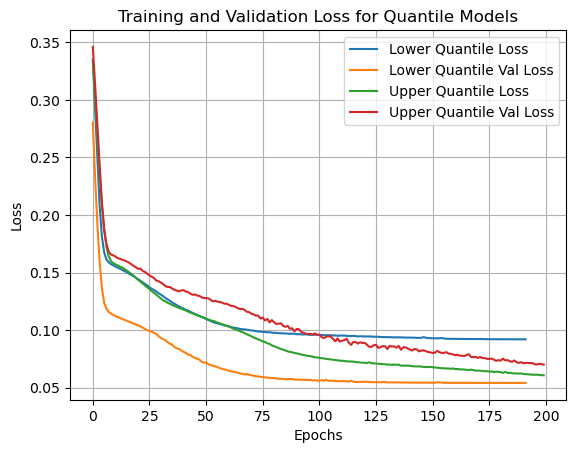

Best epoch_lower: 191, Best epoch_upper: 200
30/30 [==============================] - 0s 1ms/step
Number of reversed intervals: 0
Coverage: 0.79 (Expected: 0.8)
Average Interval Width: 8.54


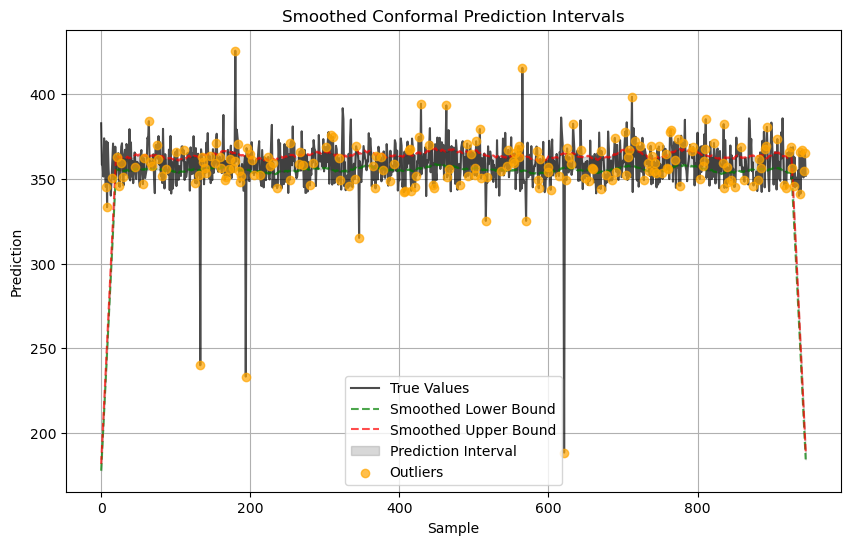

Median Prediction MAE: 3.47
Median Prediction RMSE: 9.35
Median Prediction R²: 0.50 ± 0.03


In [ ]:
# Define the pinball loss function as a closure
def pinball_loss(tau):
    def loss(y_true, y_pred):
        error = y_true - y_pred
        return tf.reduce_mean(tf.maximum(tau * error, (tau - 1) * error))
    return loss

from tensorflow.keras.optimizers import Adam

# Adjust quantile levels for wider intervals
alpha = 0.1  # Adjust alpha to create wider intervals
tau_lower = alpha      # 0.1
tau_upper = 1 - alpha  # 0.9

# Create and compile the lower quantile model
model_lower = build_model(best_hp)
model_lower.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=pinball_loss(tau_lower))

# Create and compile the upper quantile model
model_upper = build_model(best_hp)
model_upper.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=pinball_loss(tau_upper))

# Setup callbacks: Reduce LR on plateau and EarlyStopping for final training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-6)
early_stop_final = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the lower quantile model
history_lower = model_lower.fit(
    x_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[reduce_lr, early_stop_final],
    verbose=2
)

# Train the upper quantile model
history_upper = model_upper.fit(
    x_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[reduce_lr, early_stop_final],
    verbose=2
)
train_loss_per_epoch_lower = history_lower.history['loss']
best_epoch_lower = train_loss_per_epoch_lower.index(min(train_loss_per_epoch_lower)) + 1  # Define best_epoch

train_loss_per_epoch_upper = history_upper.history['loss']
best_epoch_upper = train_loss_per_epoch_upper.index(min(train_loss_per_epoch_upper)) + 1  # Define best_epoch

plt.plot(history_lower.history['loss'], label='Lower Quantile Loss')
plt.plot(history_lower.history['val_loss'], label='Lower Quantile Val Loss')
plt.plot(history_upper.history['loss'], label='Upper Quantile Loss')
plt.plot(history_upper.history['val_loss'], label='Upper Quantile Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Quantile Models')
plt.grid(True)
plt.show()

# Print the best epoch
print(f'Best epoch_lower: {best_epoch_lower}, Best epoch_upper: {best_epoch_upper}')

# Save the models
model_lower.save('I_model_lower.h5')
model_upper.save('I_model_upper.h5')

# Predict lower and upper bounds
y_data_original = y_train * Imin_abs_std + Imin_abs_mean

# Denormalize predictions for lower and upper bounds
y_lower = model_lower.predict(x_train).ravel() * Imin_abs_std + Imin_abs_mean
y_upper = model_upper.predict(x_train).ravel() * Imin_abs_std + Imin_abs_mean

#Check if the intervals are reversed
reversed_intervals = np.sum(y_lower > y_upper)
print(f"Number of reversed intervals: {reversed_intervals}")

# Predict the median (optional)
y_pred = (y_lower + y_upper) / 2  # Approximation of the median

# Evaluate the prediction intervals
# Identify outliers (true values outside the prediction intervals)
outliers = (y_data_original < y_lower) | (y_data_original > y_upper)
outliers_idx = np.where(outliers)[0]

# Calculate coverage
coverage = np.mean((y_data_original >= y_lower) & (y_data_original <= y_upper))
print(f"Coverage: {coverage:.2f} (Expected: 0.8)")

# Calculate average interval width
interval_width = np.mean(y_upper - y_lower)
print(f"Average Interval Width: {interval_width:.2f}")

# Smooth the predictions
def smooth_predictions(predictions, window_size=10):
    return np.convolve(predictions, np.ones(window_size)/window_size, mode='same')

y_lower_smooth = smooth_predictions(y_lower, window_size=40)
y_upper_smooth = smooth_predictions(y_upper, window_size=40)

# Visualize the smoothed prediction intervals
plt.figure(figsize=(10, 6))
plt.plot(y_data_original, label="True Values", color="black", alpha=0.7)
plt.plot(y_lower_smooth, label="Smoothed Lower Bound", color="green", linestyle="--", alpha=0.7)
plt.plot(y_upper_smooth, label="Smoothed Upper Bound", color="red", linestyle="--", alpha=0.7)
plt.fill_between(np.arange(len(y_data_original)), y_lower_smooth, y_upper_smooth, color='gray', alpha=0.3, label="Prediction Interval")
plt.scatter(outliers_idx, y_data_original[outliers_idx], color="orange", label="Outliers", zorder=5, alpha=0.7)
plt.title("Smoothed Conformal Prediction Intervals")
plt.xlabel("Sample")
plt.ylabel("Prediction")
plt.legend()
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_data_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_data_original, y_pred))
r2 = r2_score(y_data_original, y_pred)
print(f"Median Prediction MAE: {mae:.2f}")
print(f"Median Prediction RMSE: {rmse:.2f}")
n = len(y_data_original)
r2_error = np.sqrt((4 * r2 * (1 - r2)) / (n - 2))
print(f"Median Prediction R²: {r2:.2f} ± {r2_error:.2f}")

8/8 [==============================] - 0s 1ms/step
Test Coverage: 0.80
Test Average Interval Width: 8.32


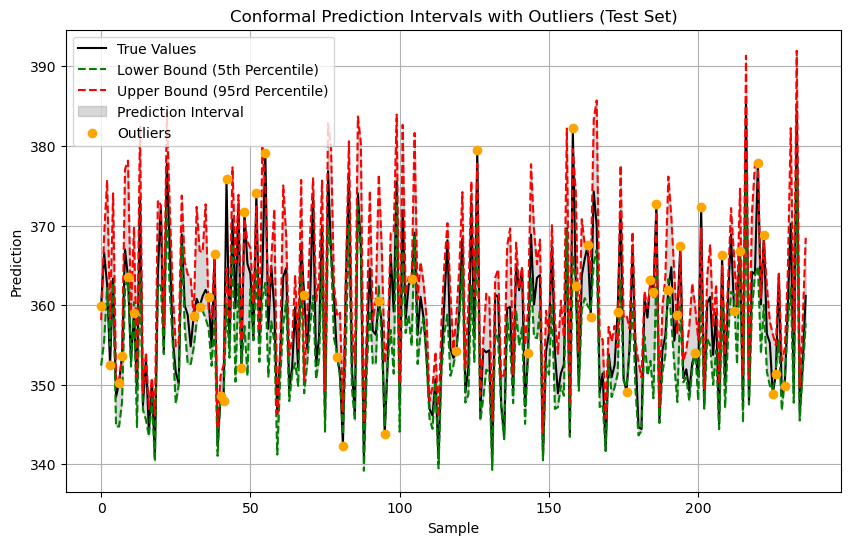

In [8]:
y_test_original = y_test * Imin_abs_std + Imin_abs_mean
y_lower_test = model_lower.predict(x_test).ravel() * Imin_abs_std + Imin_abs_mean
y_upper_test = model_upper.predict(x_test).ravel() * Imin_abs_std + Imin_abs_mean

# Calculate test coverage
coverage_test = np.mean((y_test_original >= y_lower_test) & (y_test_original <= y_upper_test))
print(f"Test Coverage: {coverage_test:.2f}")

# Calculate test interval width
interval_width_test = np.mean(y_upper_test - y_lower_test)
print(f"Test Average Interval Width: {interval_width_test:.2f}")

outliers_test = (y_test_original < y_lower_test) | (y_test_original > y_upper_test)
outliers_idx = np.where(outliers_test)[0]

plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="True Values", color="black")
plt.plot(y_lower_test, label="Lower Bound (5th Percentile)", color="green", linestyle="--")
plt.plot(y_upper_test, label="Upper Bound (95rd Percentile)", color="red", linestyle="--")
plt.fill_between(np.arange(len(y_test_original)), y_lower_test, y_upper_test, color='gray', alpha=0.3, label="Prediction Interval")
plt.scatter(outliers_idx, y_test_original[outliers_idx], color="orange", label="Outliers", zorder=5)
plt.title("Conformal Prediction Intervals with Outliers (Test Set)")
plt.xlabel("Sample")
plt.ylabel("Prediction")
plt.legend()
plt.grid(True)
plt.show()

# Load dataframe
Obtain dataframe from Load_manipulate to work on invariance

In [9]:
# Load the saved dataframe from the CSV file
dataframe = pd.read_csv('processed_data.csv')
print("Dataframe loaded successfully")

# Convert dataframe to NumPy array
dataset_np = dataframe.values
print("Dataframe converted to NumPy array")

Dataframe loaded successfully
Dataframe converted to NumPy array


In [10]:
# Invariance test
x1 = dataset_np[132,0:16]
x1_flip = x1.copy()
x1_flip = np.flip(x1)
#print(x1)
#print(x1_reverse)

# one-hot encode
x1_ohe = np.zeros((1,n_features))
x1_flip_ohe = np.zeros((1,n_features))
for j in range(n_pos):
    #atom_id = int(dataset_np[0,j])
    atom_id = int(x1[j])
    x1_ohe[0,j*n_atom_types+atom_id] = 1.0
    atom_id = int(x1_flip[j])
    x1_flip_ohe[0,j*n_atom_types+atom_id] = 1.0

print(x1)
y_pred1 = best_model.predict(x1_ohe)
print(y_pred1[0])

print()
print(x1_flip)
y_pred1_flip = best_model.predict(x1_flip_ohe)
print(y_pred1_flip[0])

[0. 3. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 111ms/step
[-0.78528845]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 3. 0.]
1/1 [==============================] - 0s 16ms/step
[-0.78528845]


# Predictions of values for all the molecules of the dataset

In [11]:
# Define the mapping of indices to atom types
atom_types = ['H', 'F', 'Cl', 'Br', 'I']

# Predict the target values for the entire dataset
y_pred_all = best_model.predict(x_data).ravel() * Imin_abs_std + Imin_abs_mean  # Denormalize predictions

# Get the indices of the top 15 predictions
top_15_indices = np.argsort(y_pred_all)[-15:][::-1]  # Sort in descending order

# Retrieve the top 15 predictions and their corresponding one-hot encoded molecules
top_15_predictions = y_pred_all[top_15_indices]
top_15_molecules = x_data[top_15_indices]

# Function to decode one-hot encoded molecule into atom type symbols
def decode_molecule(one_hot_molecule, n_pos, n_atom_types):
    molecule = []
    for i in range(n_pos):
        # Extract the one-hot encoding for the current position
        position_one_hot = one_hot_molecule[i * n_atom_types:(i + 1) * n_atom_types]
        # Find the index of the active one-hot value and map it to the atom type
        atom_index = np.argmax(position_one_hot)
        molecule.append(atom_types[atom_index])
    return molecule

# Print the results
for i, (pred, molecule_one_hot) in enumerate(zip(top_15_predictions, top_15_molecules)):
    decoded_molecule = decode_molecule(molecule_one_hot, n_pos, n_atom_types)
    print(f"Rank {i+1}: Imin = {pred:.2f}")
    print(f"Molecule: {decoded_molecule}")
    print("-" * 50)

37/37 [==============================] - 0s 2ms/step
Rank 1: Imin = 399.52
Molecule: ['I', 'I', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'I', 'I']
--------------------------------------------------
Rank 2: Imin = 394.27
Molecule: ['I', 'I', 'Br', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'Br', 'I', 'I']
--------------------------------------------------
Rank 3: Imin = 387.96
Molecule: ['I', 'Cl', 'H', 'I', 'Cl', 'H', 'Br', 'F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
--------------------------------------------------
Rank 4: Imin = 387.57
Molecule: ['Cl', 'Cl', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'I', 'I']
--------------------------------------------------
Rank 5: Imin = 387.27
Molecule: ['I', 'H', 'H', 'I', 'Br', 'H', 'Br', 'H', 'H', 'H', 'I', 'H', 'H', 'H', 'Br', 'H']
--------------------------------------------------
Rank 6: Imin = 384.59
Molecule: ['Br', 'Cl', 'H', 'H', 'H', 'H', 'H', 'Br', 'I', 'H', 'H', 'H', 'H', 'F', 'H', 'I']
-

# Prediction of a certain (no necessary in the dataset) molecule

In [12]:
# Define the mapping of atom types to indices
atom_types = ['H', 'F', 'Cl', 'Br', 'I']

# Define the new molecule's structure (example: ['H', 'F', 'Cl', 'Br', ..., 'H'])
new_molecule = ['H', 'Br', 'Br', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'Br', 'Br', 'H']

# Initialize a one-hot encoded vector for the molecule
new_molecule_ohe = np.zeros((1, n_features))  # Shape: (1, 80)

# Encode each position
for i, atom in enumerate(new_molecule):
    atom_index = atom_types.index(atom)  # Get the index of the atom type
    new_molecule_ohe[0, i * n_atom_types + atom_index] = 1.0  # Set the corresponding one-hot value

print("One-hot encoded vector for the new molecule:")
print(new_molecule_ohe)

One-hot encoded vector for the new molecule:
[[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 1. 0. 0. 0. 0.]]


In [13]:
# Predict the Imin value for the new molecule
y_pred_normalized = best_model.predict(new_molecule_ohe).ravel()  # Get the normalized prediction

# Denormalize the prediction to get the actual Imin value
y_pred = y_pred_normalized * Imin_abs_std + Imin_abs_mean

print(f"Predicted Imin for the new molecule: {y_pred[0]:.2f}")

1/1 [==============================] - 0s 13ms/step
Predicted Imin for the new molecule: 351.18


# Use of the lower and upper model to see if the predicted molecule fit in the predicted interval

In [14]:
y_lower_new = model_lower.predict(new_molecule_ohe).ravel() * Imin_abs_std + Imin_abs_mean
y_upper_new = model_upper.predict(new_molecule_ohe).ravel() * Imin_abs_std + Imin_abs_mean

print(f"Lower Bound: {y_lower_new[0]:.2f}, Upper Bound: {y_upper_new[0]:.2f}")
print(f"Prediction Interval: [{y_lower_new[0]:.2f}, {y_upper_new[0]:.2f}]")

1/1 [==============================] - 0s 105ms/step
Lower Bound: 348.83, Upper Bound: 352.94
Prediction Interval: [348.83, 352.94]


In [15]:
if y_lower_new[0] <= y_pred[0] <= y_upper_new[0]:
    print("The prediction is within the conformal prediction interval.")
else:
    print("The prediction is outside the conformal prediction interval.")

The prediction is within the conformal prediction interval.
